In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from itertools import product
from tqdm import tqdm

from device_definition import device_definition,  plotting_device_resonances, plotting_device_resonances_iter
from simplified_sequential_assignment import optimal_sequential_assignment, device_resonances_heated_func
from simplified_mrm_crr_cycling import mrm_cycling_func, crr_locking_func
from copy import deepcopy

In [2]:
tx_bank, rx_bank, laser = device_definition(no_iterations=int(2e4+1), centroid_die_variation_bool=True, laser_distribution_uniform=False)

mrm_resonances_die_wafer_variation = tx_bank["mrm_resonances_die_wafer_variation"]
crr_resonances_die_wafer_variation = rx_bank["crr_resonances_die_wafer_variation"]
ideal_resonance = tx_bank["ideal_resonances"]
laser_frequency = laser["laser_frequency"]

step_sweep = 200

no_mrm_cycling_steps = 3
no_crr_cycling_steps = 5

no_mrm_internal_alignment_steps = 20
no_crr_internal_alignment_steps = 20

debug = 1

bins = 101

In [3]:
iter_no = np.random.randint(0, 2e4+1)
print("Iteration number", iter_no)

Iteration number 6013


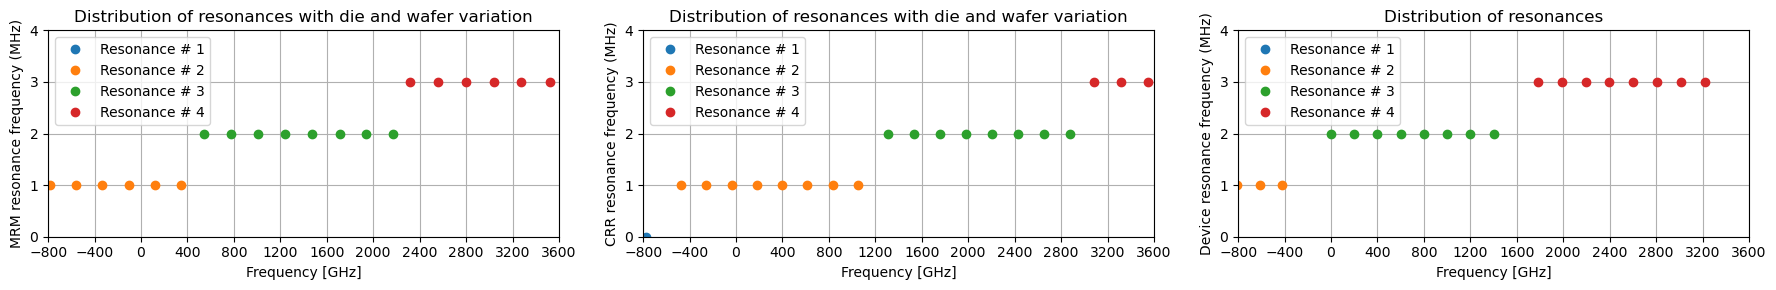

In [4]:
fig = plt.figure(figsize=(18,3))
plt.subplot(131)
plotting_device_resonances(mrm_resonances_die_wafer_variation, idd_iter=iter_no)
plt.title("Distribution of resonances with die and wafer variation")
plt.ylabel("MRM resonance frequency (MHz)")
plt.subplot(132)
plotting_device_resonances(crr_resonances_die_wafer_variation, idd_iter=iter_no)
plt.title("Distribution of resonances with die and wafer variation")
plt.ylabel("CRR resonance frequency (MHz)")
plt.subplot(133)
plotting_device_resonances(ideal_resonance, idd_iter=iter_no)
plt.title("Distribution of resonances")
plt.ylabel("Device resonance frequency (MHz)")
plt.tight_layout()
plt.show()

In [ ]:
mrm_lock_data = np.zeros((mrm_resonances_die_wafer_variation.shape[0], 7, 1))
mrm_sequential_success_metric = []
iter_satisfaction = []

mrm_laser_assigned = []
mrm_sequential_assigned = []

mrm_resonances_iter = mrm_resonances_die_wafer_variation[:, :, iter_no]

device_dict = optimal_sequential_assignment(mrm_resonances_iter, laser_frequency, device_optical_bandwidth = tx_bank["mrm_optical_bandwidth"], step_sweep = 200, debug = debug, optimization_bool=True)
heat_assigned = device_dict["heat_assigned"] + (device_dict["heat_cycling"] + device_dict["cool_cycling"]) * np.ones(mrm_resonances_iter.shape[0]) * step_sweep
heat_applied = device_dict["heat_applied"] + (device_dict["heat_cycling"] + device_dict["cool_cycling"])  * np.ones(mrm_resonances_iter.shape[0]) * step_sweep
  
optimized_heat = deepcopy(heat_assigned)
mrm_lock_data[:, 0, 0] = device_dict["device_assigned"]
mrm_lock_data[:, 1, 0] = device_dict["laser_assigned"]
mrm_lock_data[:, 2, 0] = heat_assigned
mrm_lock_data[:, 3, 0] = heat_applied
mrm_lock_data[:, 4, 0] = device_dict["resonance_assigned"]
mrm_lock_data[:, 5, 0] = device_dict["heat_cycling"]
mrm_lock_data[:, 6, 0] = device_dict["cool_cycling"]
mrm_assigned = mrm_lock_data[:, 0, 0]
if mrm_assigned[0] < 7:
  mrm_sequence = deepcopy(mrm_assigned)
  for idx in np.linspace(mrm_assigned[0], 0, int( mrm_assigned[0])+1, dtype=int):
    mrm_sequence[idx] = mrm_assigned[idx] - mrm_assigned[0]
  for idx in np.linspace(7, mrm_assigned[0]+1, 7 - int(mrm_assigned[0]), dtype=int):
    mrm_sequence[idx] = mrm_assigned[idx] - mrm_assigned[0]
else:
  mrm_sequence = deepcopy(mrm_assigned)
  
for idx, val in enumerate(mrm_sequence):
  if val < 0:
    mrm_sequence[idx] = val + 7 + 1
mrm_sequential_assigned.append(mrm_sequence)

if np.min(np.diff(mrm_sequence)) == -1 or np.max(np.diff(mrm_sequence)) == 7:
  mrm_sequential_success_metric.append(iter_no)

print("Successful sequential alignment of MRM to laser wavelengths")

In [ ]:
print("Iteration number", iter_no)
print("MRM sequence:", mrm_lock_data[:, 0, 0])
print("Laser assigned:", mrm_lock_data[:, 1, 0])
print("Heat assigned:", mrm_lock_data[:, 2, 0])
print("Heat applied:", mrm_lock_data[:, 3, 0])
print("Resonance assigned:", mrm_lock_data[:, 4, 0])
print("Heat cycling:", mrm_lock_data[:, 5, 0])
print("Cool cycling:", mrm_lock_data[:, 6, 0])

In [ ]:
device_dict

In [ ]:
cycled_mrm_dict = mrm_cycling_func(mrm_resonances_iter, laser_frequency, tx_bank["mrm_optical_bandwidth"], mrm_lock_data[:, 2, 0], mrm_lock_data[0, 5, 0]+1, step_sweep = step_sweep, debug = 0)  
cycled_mrm_dict

In [ ]:
cycled_mrm_dict_twice = mrm_cycling_func(mrm_resonances_iter, laser_frequency, tx_bank["mrm_optical_bandwidth"], mrm_lock_data[:, 2, 0], mrm_lock_data[0, 5, 0]+2, step_sweep = step_sweep, debug = 0)  
cycled_mrm_dict_twice

In [ ]:
cycled_mrm_dict_thrice = mrm_cycling_func(mrm_resonances_iter, laser_frequency, tx_bank["mrm_optical_bandwidth"], mrm_lock_data[:, 2, 0], mrm_lock_data[0, 5, 0]+3, step_sweep = step_sweep, debug = 0)  
cycled_mrm_dict_thrice

In [ ]:
cycled_mrm_dict_fourth = mrm_cycling_func(mrm_resonances_iter, laser_frequency, tx_bank["mrm_optical_bandwidth"], mrm_lock_data[:, 2, 0], mrm_lock_data[0, 5, 0]+4, step_sweep = step_sweep, debug = 0)  
cycled_mrm_dict_fourth

In [ ]:
crr_lock_post_cycling_data = np.zeros((crr_resonances_die_wafer_variation.shape[0], 6, 1))
crr_lock_success_metric = []
iter_satisfaction = []

crr_laser_assigned = []
crr_sequential_assigned = []
          
crr_resonances_iter = crr_resonances_die_wafer_variation[:, :, iter_no]
mrm_resonances_iter = mrm_resonances_die_wafer_variation[:, :, iter_no]

mrm_heat_cycling = mrm_lock_data[0, 5, 0]
mrm_assigned = mrm_lock_data[:, 0, 0]
mrm_laser_assigned =  mrm_lock_data[:, 1, 0]
mrm_heat_assigned = mrm_lock_data[:, 2, 0]

if debug:
  print("\n")
  print("Iteration number", iter_no)
  
cycled_mrm_dict, cycled_crr_dict = crr_locking_func(crr_resonances_iter, rx_bank["crr_optical_bandwidth"], mrm_resonances_iter, laser_frequency, tx_bank["mrm_optical_bandwidth"], no_mrm_cycling_steps, no_crr_cycling_steps, mrm_assigned, mrm_laser_assigned, mrm_heat_assigned, mrm_heat_cycling, step_sweep = step_sweep, debug = debug)
if len(cycled_crr_dict["crr_assigned"]) == crr_resonances_die_wafer_variation.shape[0]:  
  crr_lock_post_cycling_data[:, 0, 0] = cycled_crr_dict["crr_assigned"]
  crr_lock_post_cycling_data[:, 1, 0] = cycled_crr_dict["crr_laser_assigned"]
  crr_lock_post_cycling_data[:, 2, 0] = cycled_crr_dict["crr_heat_assigned"]
  crr_lock_post_cycling_data[:, 3, 0] = cycled_crr_dict["crr_resonance_assigned"]
  crr_lock_post_cycling_data[:, 4, 0] = cycled_crr_dict["crr_cycling_assigned"]
  crr_lock_post_cycling_data[:, 5, 0] = cycled_crr_dict["mrm_cycling_assigned"]
  crr_lock_success_metric.append(iter_no)
